In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.8.1].
device:[cuda:0].


Dataset

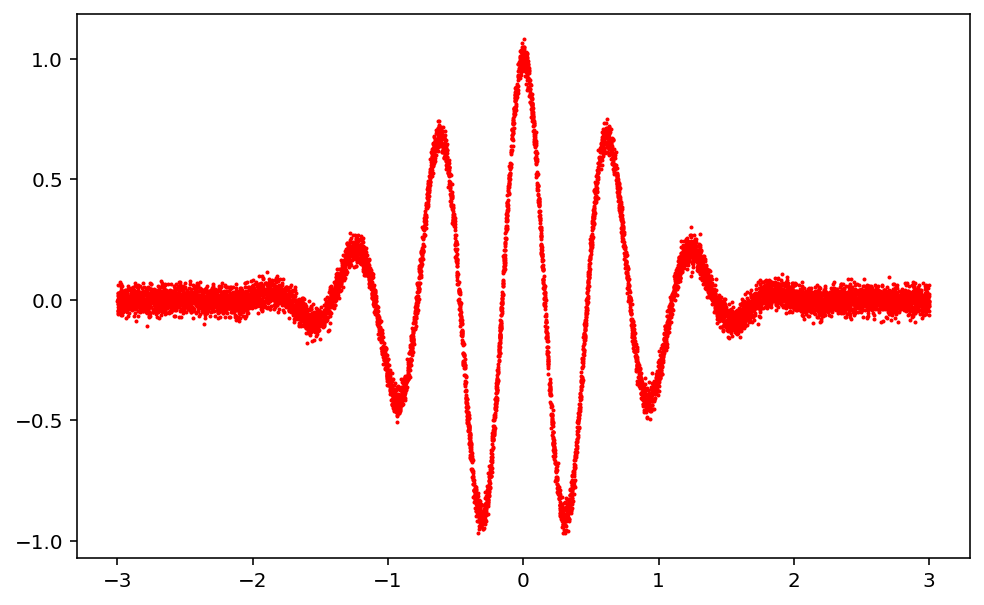

Done.


In [2]:
n_data = 10000
x_numpy = -3+6*np.random.rand(n_data,1)
y_numpy = np.exp(-(x_numpy**2))*np.cos(10*x_numpy) + 3e-2*np.random.randn(n_data,1)
plt.figure(figsize=(8,5))
plt.plot(x_numpy,y_numpy,'r.',ms=2)
plt.show()
x_torch = torch.Tensor(x_numpy).to(device)
y_torch = torch.Tensor(y_numpy).to(device)
print ("Done.")

Define Model

In [3]:
class Model(nn.Module):
    def __init__(self, name='mlp', xdim=1, hdims=[16,16], ydim=1):
        super(Model, self).__init__()
        self.name = name
        self.xdim = xdim
        self.hdims = hdims
        self.ydim = ydim
        
        self.layers = []
        prev_hdim = self.xdim
        # [xdim]->[hdim]->[hdim]->[ydim]
        for hdim in self.hdims:
            self.layers.append(nn.Linear(prev_hdim, hdim))
            self.layers.append(nn.Tanh())
            prev_hdim = hdim
        self.layers.append(nn.Linear(prev_hdim, self.ydim, bias=True))
        
        # Concat layers
        self.net = nn.Sequential()
        for l_idx, layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(), l_idx)
            self.net.add_module(layer_name, layer)
        
        self.init_param() # Initialize parameters
        
    def init_param(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.ini.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
    def forward(self, x):
        return self.net(x)
    
print("Done.")
        

Done.


1. model.parameters() : layer 이름을 제외한 parameter 값에 대한 iterator를 리턴함 
2. torch.optim.SGD(params; model.parameters(), lr= required parameter, momentum=0, dampening=0, weight_decay=0, nesterov=False)
3. torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [4]:
LEARNING_RATE = 1e-2

model_sgd = Model(name='mlp_sgd', xdim=1, hdims=[64,64], ydim=1).to(device)
model_momentum = Model(name='mlp_momentum', xdim=1, hdims=[64,64], ydim=1).to(device)
model_adam = Model(name='mlp_adam', xdim=1, hdims=[64,64], ydim=1).to(device)

loss = nn.MSELoss()
optm_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)
optm_momentum = optim.SGD(model_momentum.parameters(), lr=0.01, momentum=0.9)
optm_adam = optim.Adam(model_adam.parameters(), lr=0.01)

print("Done.")


Done.


#### Check Parameters
torch.Tensor는 .require_grad 속성을 True로 설정하면, 그 tensor에서 이뤄진 모든 연산을 추적한다. 따라서 계산이 완료된 후 .backward()를 호출하면 모든 gradient를 자동으로 계산할 수 있다. 이 변화도는 .grad 에 누적된다. 

In [5]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx, (param_name, param) in enumerate(model_sgd.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # tensor to numpy
        n_param += len(param_numpy.reshape(-1))
        print("[%d] name:[%s] shape:[%s]."%(p_idx, param_name, param_numpy.shape))
        print("    val:%s"%(param_numpy.reshape(-1)[:5]))
        
print("Total number of parameters:[%s]."%(format(n_param,',d')))
    

[0] name:[net.linear_00.weight] shape:[(64, 1)].
    val:[-0.861  1.734 -0.532 -0.339 -0.924]
[1] name:[net.linear_00.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[net.linear_02.weight] shape:[(64, 64)].
    val:[ 0.131 -0.163 -0.05  -0.022  0.172]
[3] name:[net.linear_02.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[4] name:[net.linear_04.weight] shape:[(1, 64)].
    val:[ 0.203 -0.139 -0.01   0.203  0.103]
[5] name:[net.linear_04.bias] shape:[(1,)].
    val:[0.]
Total number of parameters:[4,353].


#### Train
1. r_idx 는 batch size만큼 샘플링한 데이터 idx이다. 
2. data_iter : train_set image (=batch_x), label (=batch_y)

1. optimizer.zero_grad() : iteration이 다시 시작할 때, gradient를 0으로 초기화해준다.  
2. loss.backward() : backpropagation 진행하며 gradient를 계산한다. 
3. optimizer.step() : 계산한 gradient를 통해 parameter를 update한다. 

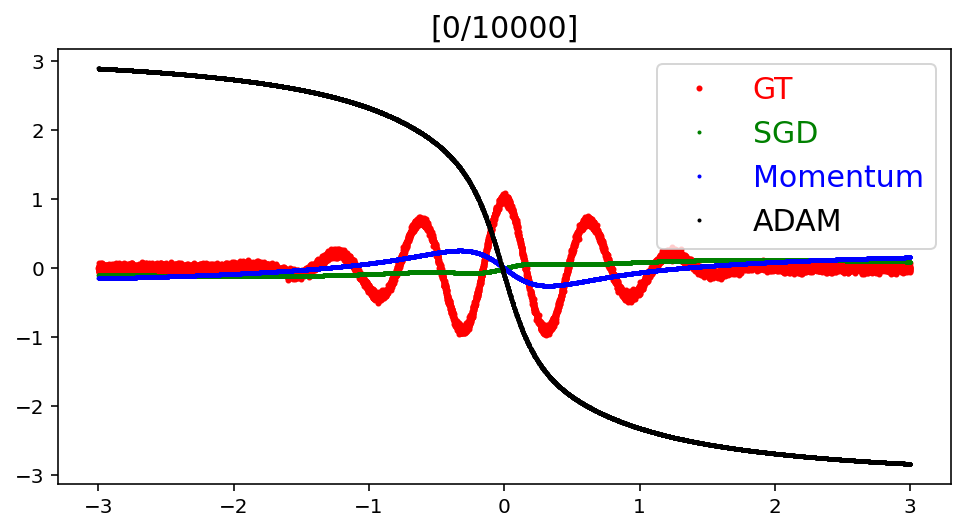

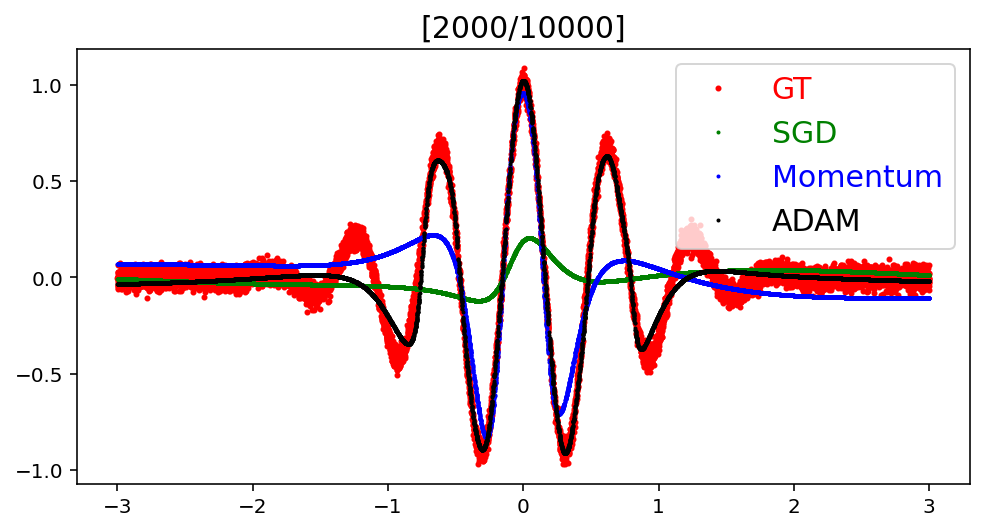

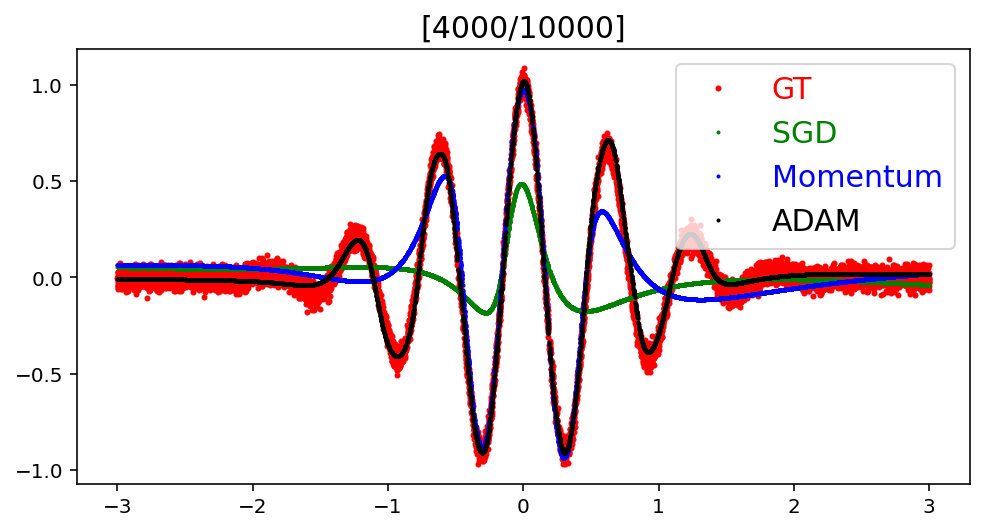

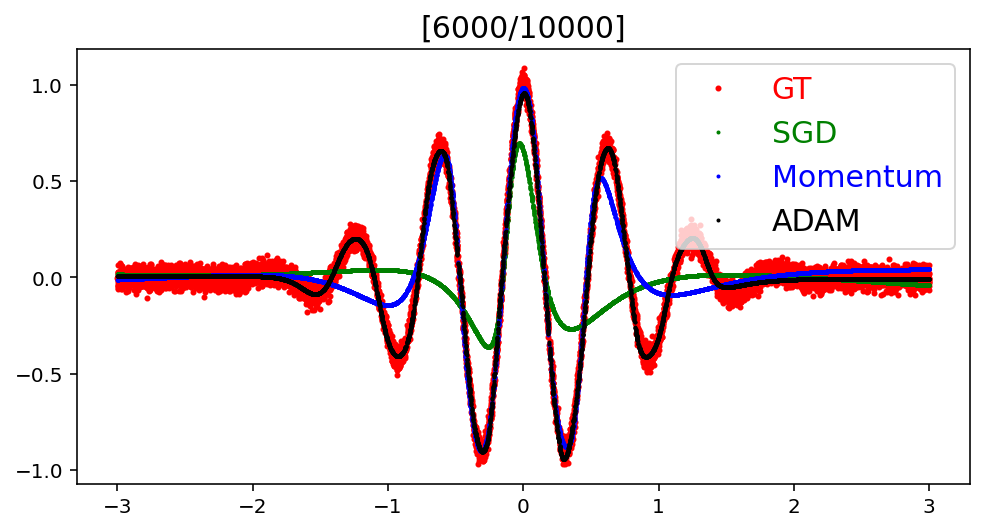

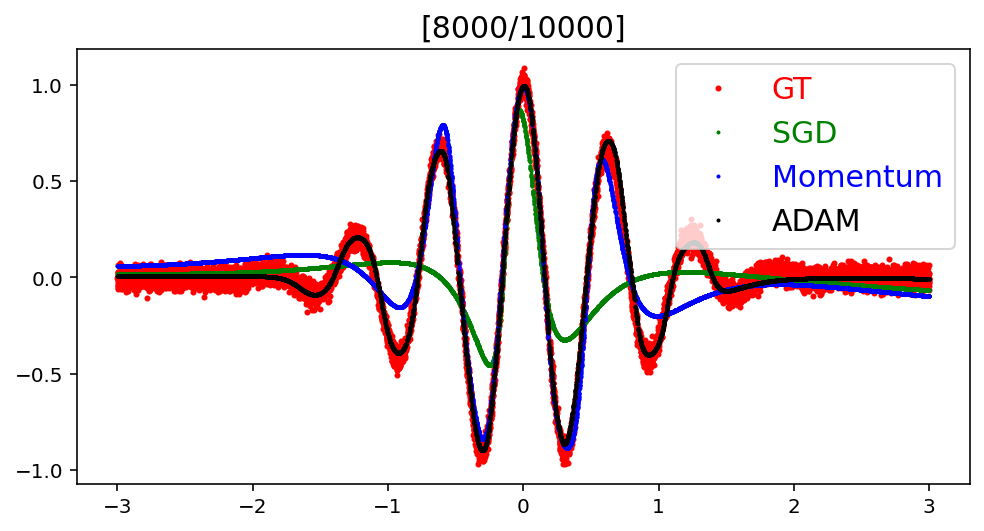

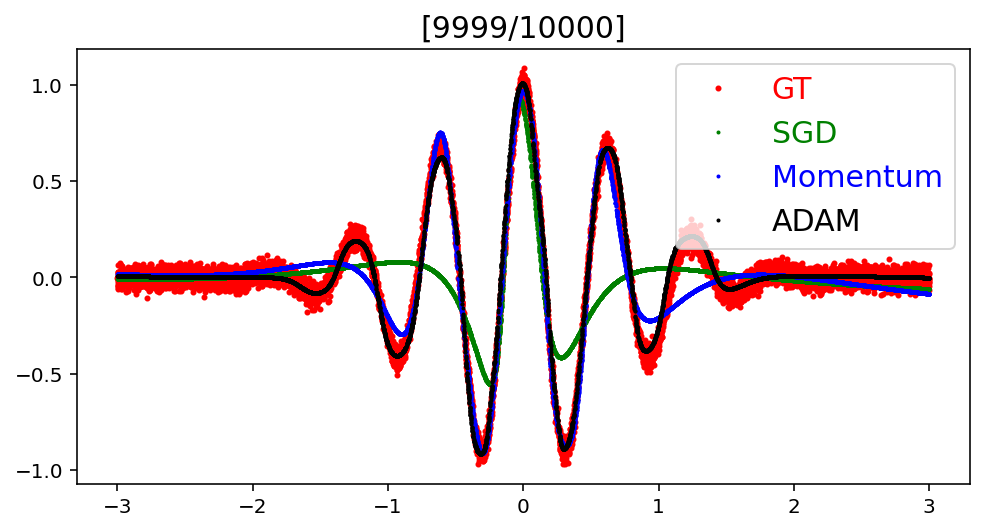

Done.


In [6]:
MAX_ITER, BATCH_SIZE, PLOT_EVERY = 1e4, 64, 2000

model_sgd.init_param()
model_momentum.init_param()
model_adam.init_param()

model_sgd.train()
model_momentum.train()
model_adam.train()

for it in range(int(MAX_ITER)):
    r_idx = np.random.permutation(n_data)[:BATCH_SIZE]
    batch_x, batch_y = x_torch[r_idx], y_torch[r_idx]
    
    #Update with Adam
    y_pred_adam = model_adam.forward(batch_x)
    loss_adam = loss(y_pred_adam, batch_y)
    optm_adam.zero_grad()
    loss_adam.backward()
    optm_adam.step()
    
    #update with Momentum
    y_pred_momentum = model_momentum.forward(batch_x)
    loss_momentum = loss(y_pred_momentum, batch_y)
    optm_momentum.zero_grad()
    loss_momentum.backward()
    optm_momentum.step()
    
    #Update with SGD
    y_pred_sgd = model_sgd.forward(batch_x)
    loss_sgd = loss(y_pred_sgd, batch_y)
    optm_sgd.zero_grad()
    loss_sgd.backward()
    optm_sgd.step()
    
    #Plot
    if ((it%PLOT_EVERY)==0) or (it==0) or (it==(MAX_ITER-1)):
        with torch.no_grad():
            y_sgd_numpy = model_sgd.forward(x_torch).cpu().detach().numpy()
            y_momentum_numpy = model_momentum.forward(x_torch).cpu().detach().numpy()
            y_adam_numpy = model_adam.forward(x_torch).cpu().detach().numpy()
            
            plt.figure(figsize=(8,4))
            plt.plot(x_numpy, y_numpy, 'r.', ms=4, label='GT')
            plt.plot(x_numpy, y_sgd_numpy, 'g.', ms=2, label='SGD')
            plt.plot(x_numpy, y_momentum_numpy, 'b.', ms = 2, label='Momentum')
            plt.plot(x_numpy, y_adam_numpy, 'k.', ms=2, label='ADAM')
            plt.title("[%d/%d]"%(it,MAX_ITER),fontsize=15)
            plt.legend(labelcolor='linecolor',loc='upper right',fontsize=15)
            plt.show()

print ("Done.")